In [631]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [632]:
device = torch.device("cuda")


EPOCHS = 3000
learning_rate = 0.0005
memory = 28
batch_size = 1000

In [633]:

# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [634]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)

    # combined_tables.append(combined_table)
    combined_tables.append(tables)
    del(df, tables, combined_table)

combined_tables[1] = [combined_tables[1][i].reindex(columns=combined_tables[0][0].columns) for i in range(4)]

for i in range(3):
    for j in range(4):
        combined_tables[i][j] = combined_tables[i][j][sorted(combined_tables[i][j].columns)]

reservoir = pd.DataFrame([combined_tables[i][j].iloc[4] for i in range(3) for j in range(4)]).reset_index(drop=True)

In [635]:
# df = pd.read_excel("./data/reservoir_yasir.xlsx")

# reservoir = pd.DataFrame({ [int(format(i, '04b')) for i in range(reservoir.shape[1])][i] :[df['drain current'][i]] for i in range(16)  })

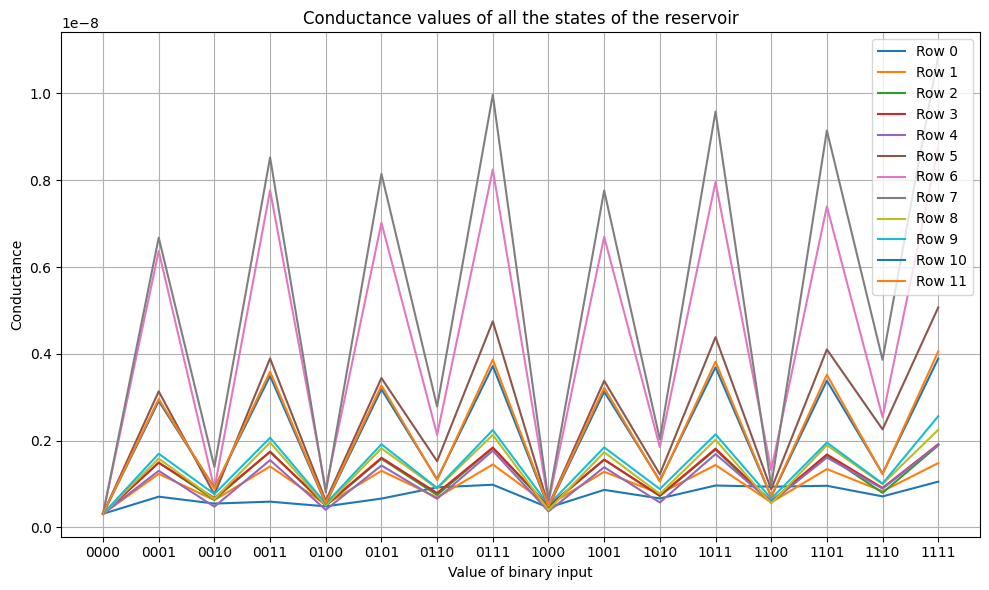

In [636]:

# Plotting each row
plt.figure(figsize=(10, 6))

x_labels = [format(i, '04b') for i in range(reservoir.shape[1])]
for idx, row in reservoir.iterrows():
    plt.plot(x_labels, row.values, label=f'Row {idx}')

plt.xlabel('Value of binary input')
plt.ylabel('Conductance')
plt.title('Conductance values of all the states of the reservoir')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [637]:

def generate_nonlinear_system(N, seed=None):
    if seed is not None:
        np.random.seed(seed)

    u = np.random.uniform(0, 0.5, size=N)
    y = np.zeros(N)

    # Initialize y[-1] and y[0]
    # y_prev2 = np.random.randn()  # y_{k-2}
    # y_prev1 = np.random.randn()  # y_{k-1}

    y_prev2 = 0  # y_{k-2}
    y_prev1 = 0  # y_{k-1}
    for k in range(N):
        y_k = 0.4 * y_prev1 + 0.4 * y_prev1 * y_prev2 + 0.6 * u[k]**3 + 0.1
        y[k] = y_k

        # Update history
        y_prev2 = y_prev1
        y_prev1 = y_k

    return y, u


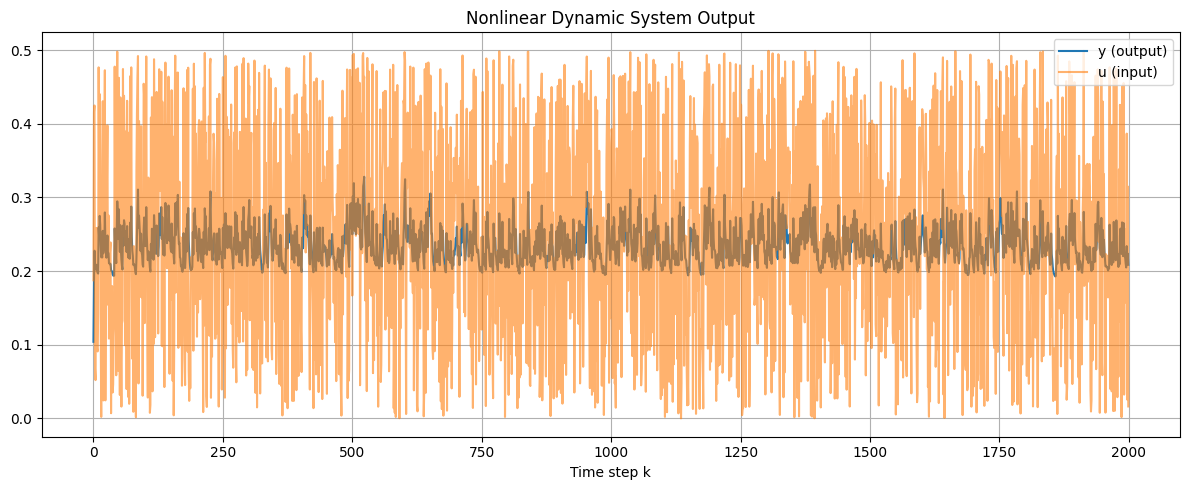

In [638]:
import matplotlib.pyplot as plt

N = 2_000
y, u = generate_nonlinear_system(N)

plt.figure(figsize=(12, 5))
plt.plot(y, label='y (output)')
plt.plot(u, label='u (input)', alpha=0.6)
plt.title('Nonlinear Dynamic System Output')
plt.xlabel('Time step k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [639]:
class CustomDataset(Dataset):
    def __init__(self, u:np.array, y:np.array, reservoir:pd.DataFrame, memory:int, start:int, end:int, device=device):
        if len(u) != len(y):
            raise ValueError("Input arrays are not of same shape")
        if len(u) == 0 or len(y) == 0:
            raise ValueError("Input array cannot be empty")
        if memory < 0:
            raise ValueError(f"`memory` must be a non-negative value, got {memory}")
        if start < 0:
            raise ValueError(f"`start` must be a non-negative value, got {start}")
        # if start < memory:
        #     raise ValueError(f"`memory` = {memory} can not be greater than `start` = {start}")
        if end <= 0 or end > len(u):
            raise ValueError(f"`end` must be in range 0 to `len(`u`)` got {end}")
        if start >= end:
            raise ValueError(f"`start` must be smaller than `end` =  {end}, got {start}")
        self.u, self.y = u, y
        super().__init__()
        # normalized input values
        u_normalized = (u - u.min()) / (u.max() - u.min())
        # quantized input values
        u_quantized = np.round(u_normalized * 15).astype(int)
        self.u_quantized = u_quantized
        # binarizing the quantized input
        binary_u = list(map(int, [format(val, '04b') for val in u_quantized]))
        self.binary_u = binary_u
        X = reservoir[binary_u].to_numpy().T / reservoir.to_numpy().max()
        self.X = X

        
        # result = np.zeros((end - start, (memory+1) * X.shape[1]))
        result = []

        for idx in range(start, end):
            ref = X[idx]  
            diffs = [ref]

            for j in range(idx - memory, idx):
                if j < 0:
                    prev = np.zeros(X.shape[1])
                else:
                    prev = X[j]
                diffs.append(ref - prev)
            

            # result[i] = np.concatenate(diffs)
            result.append(diffs)

        result = np.array(result).reshape((end-start, -1))
        # result = np.clip(result, a_min=0, a_max=None)
        

        self.processed_data = torch.tensor(result, dtype=torch.float).to(device=device)
        self.labels = torch.tensor(y, dtype=torch.float).reshape((y.shape[0], 1)).to(device=device)

    
    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]
    


# ds = CustomDataset(u, y, reservoir, 19, 0, 1000)          



        
        


In [640]:
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

In [641]:
u_train, y_train = u[250:1750], y[250:1750]
u_test, y_test = u[1750:], y[1750:]
train_ds = CustomDataset(u_train, y_train, 
                         reservoir=reservoir, 
                         memory=memory,
                         start=0,
                         end=len(u_train)
                         )

test_ds = CustomDataset(u_test, y_test,
                        reservoir=reservoir,
                        memory=memory,
                        start=0,
                        end=len(u_test)
                        )

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [642]:
model = ReadoutLayer((memory+1) * reservoir.shape[0]).to(device=device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses, all_nmse = [], []
def nmse_db(pred, target):
    mse = ((pred - target) ** 2).sum()
    power = (target ** 2).sum()
    nmse = mse / power
    return 10 * torch.log10(nmse)


def ridge_loss(output, target, model, lambda_reg):
    def nmse_loss(pred, target):
        mse = torch.sum((pred - target) ** 2)
        power = torch.sum(target ** 2) + 1e-10
        # return 10 * torch.log10(mse / power)
        return mse/power

    # mse_loss = nn.MSELoss()(output, target)
    # mse_loss = nn.SmoothL1Loss(beta=1.0)(output, target)
    mse_loss = nmse_loss(output, target)
    l2_reg = sum((param**2).sum() for param in model.parameters())
    return mse_loss + lambda_reg * l2_reg




In [643]:
train_ds.processed_data.shape

torch.Size([1500, 348])

In [644]:
for epoch in range(15000):
    model.train()
    epoch_loss = 0.0
    all_preds = []
    all_targets = []
    for vectors, targets in train_loader:
        vectors, targets = vectors.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(vectors.float())
        loss = ridge_loss(outputs, targets, model, 0)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * vectors.size(0)  # weighted by batch size
        all_preds.append(outputs.detach())
        all_targets.append(targets.detach())

    preds = torch.cat(all_preds, dim=0)
    targets = torch.cat(all_targets, dim=0)

    nmse = nmse_db(preds, targets)

    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    all_nmse.append(-nmse.item())
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, NMSE [dB]: {nmse.item():.2f}")

Epoch 1, Loss: 1.1833, NMSE [dB]: 0.73
Epoch 2, Loss: 1.0766, NMSE [dB]: 0.32
Epoch 3, Loss: 1.0215, NMSE [dB]: 0.09
Epoch 4, Loss: 0.9966, NMSE [dB]: -0.01
Epoch 5, Loss: 0.9756, NMSE [dB]: -0.11
Epoch 6, Loss: 0.9463, NMSE [dB]: -0.24
Epoch 7, Loss: 0.9104, NMSE [dB]: -0.41
Epoch 8, Loss: 0.8741, NMSE [dB]: -0.58
Epoch 9, Loss: 0.8418, NMSE [dB]: -0.75
Epoch 10, Loss: 0.8143, NMSE [dB]: -0.89
Epoch 11, Loss: 0.7893, NMSE [dB]: -1.03
Epoch 12, Loss: 0.7638, NMSE [dB]: -1.17
Epoch 13, Loss: 0.7367, NMSE [dB]: -1.33
Epoch 14, Loss: 0.7088, NMSE [dB]: -1.50
Epoch 15, Loss: 0.6816, NMSE [dB]: -1.66
Epoch 16, Loss: 0.6563, NMSE [dB]: -1.83
Epoch 17, Loss: 0.6327, NMSE [dB]: -1.99
Epoch 18, Loss: 0.6100, NMSE [dB]: -2.15
Epoch 19, Loss: 0.5876, NMSE [dB]: -2.31
Epoch 20, Loss: 0.5656, NMSE [dB]: -2.47
Epoch 21, Loss: 0.5444, NMSE [dB]: -2.64
Epoch 22, Loss: 0.5243, NMSE [dB]: -2.80
Epoch 23, Loss: 0.5051, NMSE [dB]: -2.97
Epoch 24, Loss: 0.4866, NMSE [dB]: -3.13
Epoch 25, Loss: 0.4685, NMSE

In [645]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        all_preds.append(preds.detach().cpu())
        all_targets.append(y.detach().cpu())

preds = torch.cat(all_preds[memory:], dim=0)
targets = torch.cat(all_targets[memory:], dim=0)

mse = ((preds - targets) ** 2).sum()
power = (targets ** 2).sum()
nmse = mse / power
print(f"Test NMSE [dB]: {10 * torch.log10(nmse):.2f}")

RuntimeError: torch.cat(): expected a non-empty list of Tensors

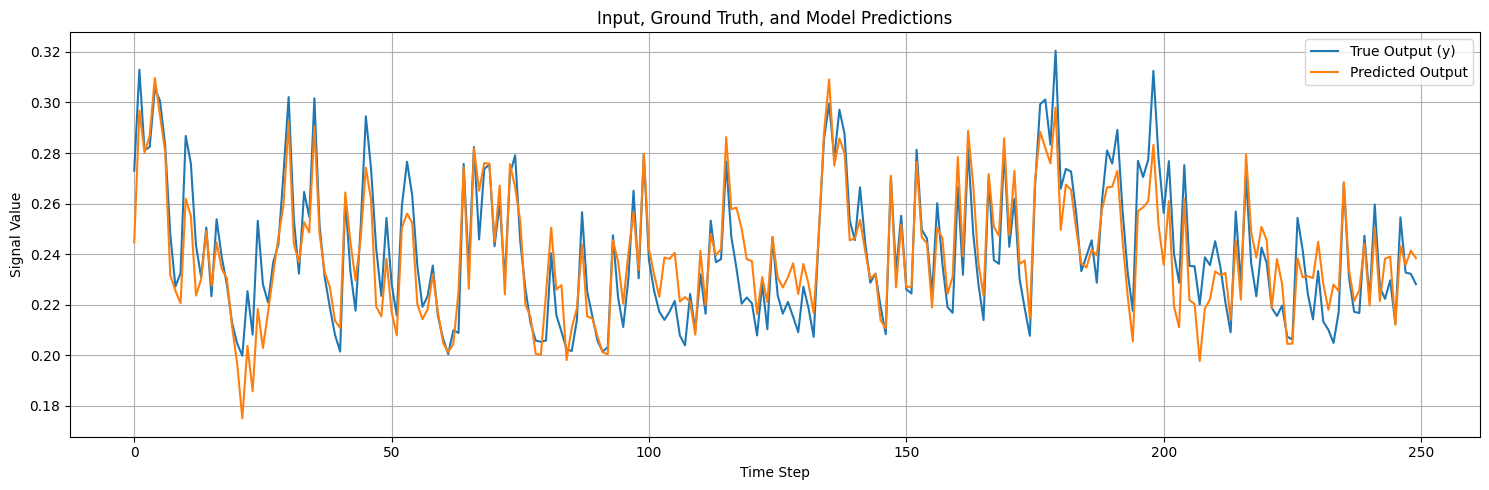

In [ ]:
u = (test_ds.u_quantized * 0.5 / 16)[memory:]
y = test_ds.y[memory:]
preds = preds.squeeze()

# If preds is batched (2D), flatten it
# if preds.ndim > 1:
#     preds = preds.squeeze()

# Plot
plt.figure(figsize=(15, 5))
# plt.plot(u, label='Input (u)', linestyle='--')
plt.plot(y, label='True Output (y)')
plt.plot(preds, label='Predicted Output')
plt.legend()
plt.title("Input, Ground Truth, and Model Predictions")
plt.xlabel("Time Step")
plt.ylabel("Signal Value")
plt.grid(True)
plt.tight_layout()
plt.show()

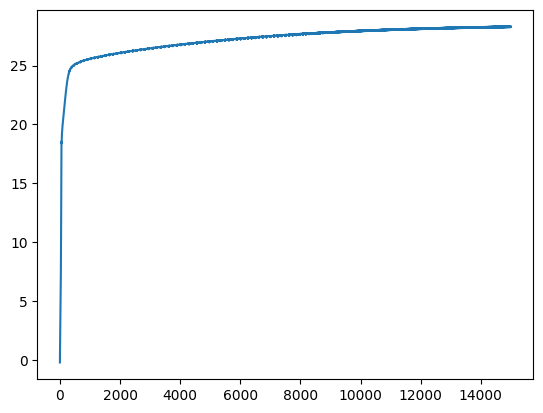

In [ ]:
plt.plot(all_nmse)